#### 라이브러리 정의

In [1]:
import pandas as pd
import numpy as np

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

### 경고(오류는 아님) 메시지 없애기
# - 사이킷런 버전에 따라 오류가 아니니 안내(경고)메시지가 자주 나타남
# - 안내(경고) 메시지 없이 실행할 수 있도록 처리
from sklearn import set_config
set_config(display="text")

# - 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

#### 파일 불러들이고 결측치 처리

In [2]:
# 데이터 불러오기
merged_wildfire_df = pd.read_csv("./data/csv/merged_wildfire_weather.csv", dtype={'version': str})

# 데이터 일부 확인
print("데이터 일부 확인:\n", merged_wildfire_df.head())

# datetime 변환
merged_wildfire_df['datetime'] = pd.to_datetime(merged_wildfire_df['datetime'])

# 결측치 확인
print("결측치 개수 (처리 전):\n", merged_wildfire_df.isnull().sum())

데이터 일부 확인:
    latitude  longitude  brightness  scan  track    acq_date satellite  \
0 -34.46005  150.88739      337.26  0.42   0.38  2015-01-01         N   
1 -34.45472  150.87651      336.26  0.42   0.38  2015-01-01         N   
2 -34.46084  150.88281      342.15  0.42   0.38  2015-01-01         N   
3 -33.31349  150.62228      332.79  0.42   0.38  2015-01-01         N   
4 -33.31002  150.62143      338.80  0.42   0.38  2015-01-01         N   

  instrument confidence version  bright_t31   frp daynight  type        T2M  \
0      VIIRS          n       2      300.09  6.08        D   2.0  23.542729   
1      VIIRS          n       2      302.46  3.46        D   2.0  23.549633   
2      VIIRS          n       2      302.23  6.08        D   2.0  23.544854   
3      VIIRS          n       2      301.44  3.29        D   0.0  25.627192   
4      VIIRS          n       2      302.00  3.29        D   0.0  25.627632   

       WS2M       RH2M  PRECTOTCORR             datetime  
0  3.046357  77

In [3]:
# 결측치 처리 (결측치가 없더라도 명시적으로 처리)
# 현재는 결측치가 없으므로 이 단계는 스킵되지만, 코드에 포함시켜 안정성 확보
merged_wildfire_df = merged_wildfire_df.dropna()

# 불필요한 컬럼 삭제
columns_to_drop = ['scan', 'track', 'satellite', 'instrument', 'version', 'type', "acq_date"]
merged_wildfire_df = merged_wildfire_df.drop(columns=columns_to_drop)

In [4]:
# 데이터 타입 & 구조 확인
print("데이터 타입:\n", merged_wildfire_df.dtypes)

데이터 타입:
 latitude              float64
longitude             float64
brightness            float64
confidence             object
bright_t31            float64
frp                   float64
daynight               object
T2M                   float64
WS2M                  float64
RH2M                  float64
PRECTOTCORR           float64
datetime       datetime64[ns]
dtype: object


In [5]:
# 결측치 확인 (처리 후)
print("결측치 개수 (처리 후):\n", merged_wildfire_df.isnull().sum())

결측치 개수 (처리 후):
 latitude       0
longitude      0
brightness     0
confidence     0
bright_t31     0
frp            0
daynight       0
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
datetime       0
dtype: int64


#### 데이터 프레임 이상치 확인 및 처리

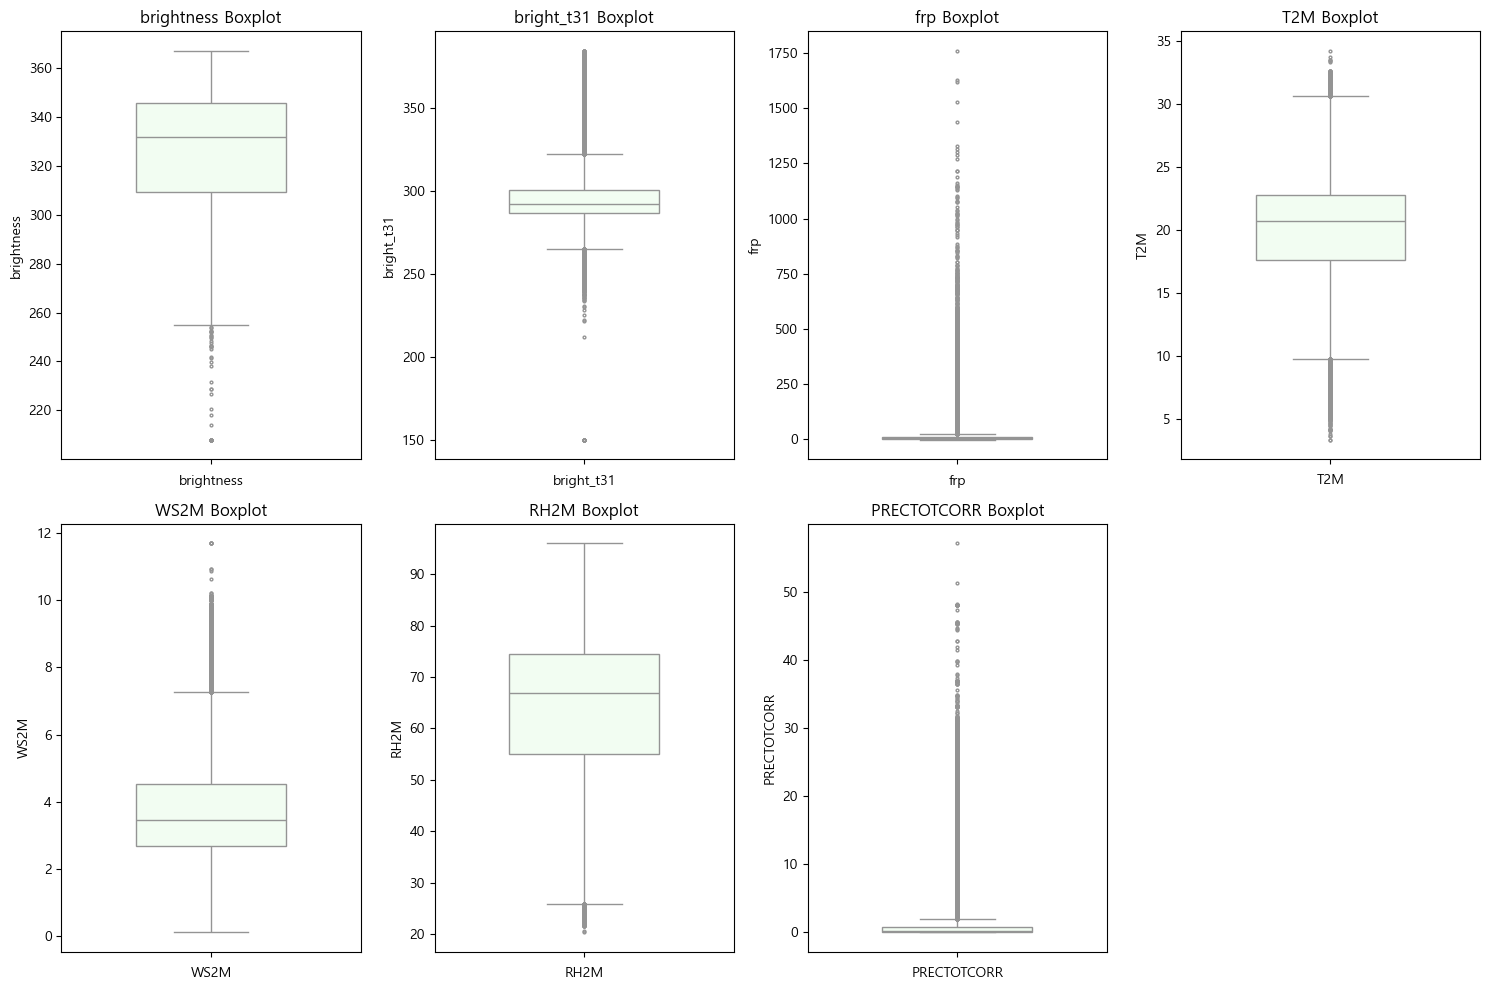

In [6]:
# 여러 변수에 대해 boxplot을 한 번에 그리기
plt.figure(figsize=(15, 10))

# 각 변수에 대해 Boxplot 생성
variables = ["brightness", "bright_t31", "frp", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for i, v in enumerate(variables, 1):
    plt.subplot(2, 4, i) # 2행 4열
    sns.boxplot(merged_wildfire_df[v], 
                width=.5,
                fliersize=2,
                color="honeydew")
    plt.title(f"{v} Boxplot")
    plt.xlabel(v)

plt.tight_layout()
plt.show()

# 이상치 확인을 위해 각 컬럼별 Boxplot를 그려 확인함
# "brightness", "T2M", "WS2M", "RH2M"컬럼의 이상치는 범위의 차이가 크지 않아 이상치로 보지 않음
# "bright_t31" 컬럼은 산불의 밝기를 보여주는 값인데 해당 컬럼의 값의 범주를 확인 했을 때 값의 범주보다 낮거나 높은 이상치들은 산불의 강도에 영향을 받을 수 있음으로
#   값이 범주보다 크다고 하여 이상치로 보기 어렵다 판단하여 이상치 처리를 하지 않음 
# "frp", "PRECTOTCORR" 값의 범위의 차이가 큰 데이터들이 있어 직접 확인후 판단하는 과정 진행

In [7]:
# IQR 계산 및 이상치 처리 함수
def calculate_iqr(df, columns):
    iqr_results = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        iqr_results[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outliers': outliers
        }
    
    return iqr_results

columns_to_check = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]

# Pandas 데이터프레임에서 바로 처리
iqr_results = calculate_iqr(merged_wildfire_df, columns_to_check)

# 결과 출력
for col, result in iqr_results.items():
    print(f"Column: {col}")
    print(f"  Q1: {result['Q1']}")
    print(f"  Q3: {result['Q3']}")
    print(f"  IQR: {result['IQR']}")
    print(f"  Lower Bound: {result['Lower Bound']}")
    print(f"  Upper Bound: {result['Upper Bound']}")
    print(f"  Outliers Count: {result['Outliers Count']}")
    print("")
    
    import pandas as pd

Column: frp
  Q1: 1.71
  Q3: 9.64
  IQR: 7.930000000000001
  Lower Bound: -10.185000000000002
  Upper Bound: 21.535000000000004
  Outliers Count: 133057

Column: brightness
  Q1: 309.09
  Q3: 345.51
  IQR: 36.420000000000016
  Lower Bound: 254.45999999999995
  Upper Bound: 400.14
  Outliers Count: 768

Column: bright_t31
  Q1: 286.23
  Q3: 300.6
  IQR: 14.370000000000005
  Lower Bound: 264.675
  Upper Bound: 322.15500000000003
  Outliers Count: 33951

Column: T2M
  Q1: 17.603074646769034
  Q3: 22.80893481136254
  IQR: 5.205860164593506
  Lower Bound: 9.794284399878775
  Upper Bound: 30.6177250582528
  Outliers Count: 7272

Column: WS2M
  Q1: 2.6899001728889864
  Q3: 4.519847583470627
  IQR: 1.8299474105816405
  Lower Bound: -0.055020942983474264
  Upper Bound: 7.2647686993430876
  Outliers Count: 8809

Column: RH2M
  Q1: 55.00033744172387
  Q3: 74.40400028661996
  IQR: 19.40366284489609
  Lower Bound: 25.894843174379737
  Upper Bound: 103.50949455396409
  Outliers Count: 1134

Column: 

In [8]:
### frp(산불의 열 방출량) 이상치 확인
# 이상치데이터 frp(산불의 열 방출량) 데이터를 확인해 보기위해서 "frp"을 기준으로 오름차순 정리함
# 2019년 9월 2일 호주 남동부 지방에서 2020년 2월 13일 진화된 산불이 있었음
# 해당 기간 외 다른 값들과 비교 했을때 frp값이 큰 변화폭이 있을 수 있음으로 상위의 값은 이상치로 판단하지 않음
# 단, 이상치데이터 frp(산불의 열 방출량)값이 0 이하인 값들은 0으로 처리
merged_wildfire_df.sort_values(by="frp", ascending=False)

,latitude,longitude,brightness,confidence,bright_t31,frp,daynight,T2M,WS2M,RH2M,PRECTOTCORR,datetime
834373,-37.15503,149.29337,367.00,h,329.95,1761.20,N,23.396893,6.523320,82.299148,0.198701,2020-01-04 15:21:00
731379,-37.75735,149.35200,367.00,h,340.50,1628.73,N,22.275182,4.603199,82.575545,0.414768,2019-12-29 15:34:00
893812,-36.97441,149.41075,347.72,n,299.72,1618.35,D,24.874119,6.811179,86.525618,0.070732,2020-01-31 03:54:00
507518,-33.26635,150.73674,208.00,l,321.90,1527.79,D,22.002932,1.079204,33.894783,0.010657,2019-11-15 04:39:00
893581,-36.99637,149.40254,342.43,n,304.81,1435.91,D,24.876063,6.806951,86.491494,0.071280,2020-01-31 03:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...
809799,-35.87612,148.37096,367.00,l,347.34,-3.21,D,24.870724,5.802931,75.992279,0.148805,2020-01-04 04:00:00
818452,-35.94544,147.93570,367.00,l,383.39,-3.24,D,24.878152,5.815845,75.833169,0.147681,2020-01-04 04:00:00
817133,-36.05280,149.74945,367.00,l,380.95,-3.26,D,24.017309,6.228422,80.200567,0.171385,2020-01-04 04:00:00
818451,-35.94612,147.93141,367.00,l,383.71,-3.44,D,24.878231,5.815936,75.831646,0.147668,2020-01-04 04:00:00


In [9]:
### PRECTOTCORR(강수량) 이상치 확인
# 이상치데이터 PRECTOTCORR(강수량) 데이터를 확인해 보기위해서 "PRECTOTCORR"을 기준으로 오름차순 정리함
# 화재 진압을 위해 소방 헬기로 물을 뿌리는 경우 강수량으로 측정 되는 경우가 있음을 확인
# 해당 경우 화재 진압 시간이 단축될 수록 피해 면적이 줄어드는 결과가 있기 때문에 강수량의 경우 이상치 처리하지 않음
merged_wildfire_df.sort_values(by="PRECTOTCORR", ascending=False)

,latitude,longitude,brightness,confidence,bright_t31,frp,daynight,T2M,WS2M,RH2M,PRECTOTCORR,datetime
916023,-30.44218,152.85500,331.48,n,289.06,3.10,N,21.522352,1.208007,91.284352,57.081657,2020-02-13 14:28:00
1033543,-34.51231,150.33804,296.99,n,286.86,0.63,N,20.748802,3.116883,89.173775,51.260057,2023-02-09 14:57:00
953664,-34.46334,150.88200,316.47,n,290.65,4.20,N,20.364792,5.977936,91.672239,48.116256,2021-03-23 14:55:00
953667,-34.45763,150.87729,329.22,n,290.24,2.78,N,20.362949,5.969096,91.682047,48.076576,2021-03-23 14:55:00
953665,-34.46001,150.88280,343.01,n,292.75,4.20,N,20.368243,5.981995,91.671236,48.039242,2021-03-23 14:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...
396101,-32.24490,150.93738,299.27,n,288.53,1.58,N,21.093145,1.256036,37.066865,0.000004,2019-10-03 14:24:00
666546,-32.24536,150.93578,303.11,n,289.76,0.85,N,23.192698,3.599160,45.589728,0.000004,2019-12-17 14:17:00
666739,-32.24545,150.93521,301.84,n,289.67,0.78,N,23.193006,3.599195,45.587629,0.000004,2019-12-17 14:17:00
352650,-32.24724,150.93709,297.40,n,281.62,1.14,N,10.026794,2.413240,56.825811,0.000003,2019-07-21 15:52:00


In [10]:
# 이상치 처리 함수
def handle_outliers(df):
    # FRP (Fire Radiative Power) 처리
    df['frp'] = df['frp'].clip(lower=0)  # FRP는 0 이상만 유지
    
    # WS2M (2m 높이 풍속) 처리: 상한선만 설정
    df['WS2M'] = df['WS2M'].clip(lower=0)

    # RH2M (2m 높이 상대습도) 처리
    df['RH2M'] = df['RH2M'].clip(lower=0)
    return df

# 이상치 처리
australia_pd_data = handle_outliers(merged_wildfire_df)

In [11]:
# 처리 후 데이터 확인
print(australia_pd_data[['frp', 'brightness', 'bright_t31', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR']].head())

    frp  brightness  bright_t31        T2M      WS2M       RH2M  PRECTOTCORR
0  6.08      337.26      300.09  23.542729  3.046357  77.197443     0.438096
1  3.46      336.26      302.46  23.549633  3.033239  77.120944     0.437495
2  6.08      342.15      302.23  23.544854  3.039431  77.155237     0.437809
3  3.29      332.79      301.44  25.627192  0.431325  61.538323     0.385476
4  3.29      338.80      302.00  25.627632  0.430816  61.535016     0.385449


In [12]:
# 데이터 타입 확인
print(australia_pd_data.dtypes)  # 이제 불필요한 컬럼이 제거되었는지 확인

latitude              float64
longitude             float64
brightness            float64
confidence             object
bright_t31            float64
frp                   float64
daynight               object
T2M                   float64
WS2M                  float64
RH2M                  float64
PRECTOTCORR           float64
datetime       datetime64[ns]
dtype: object


#### 상관관계 검증

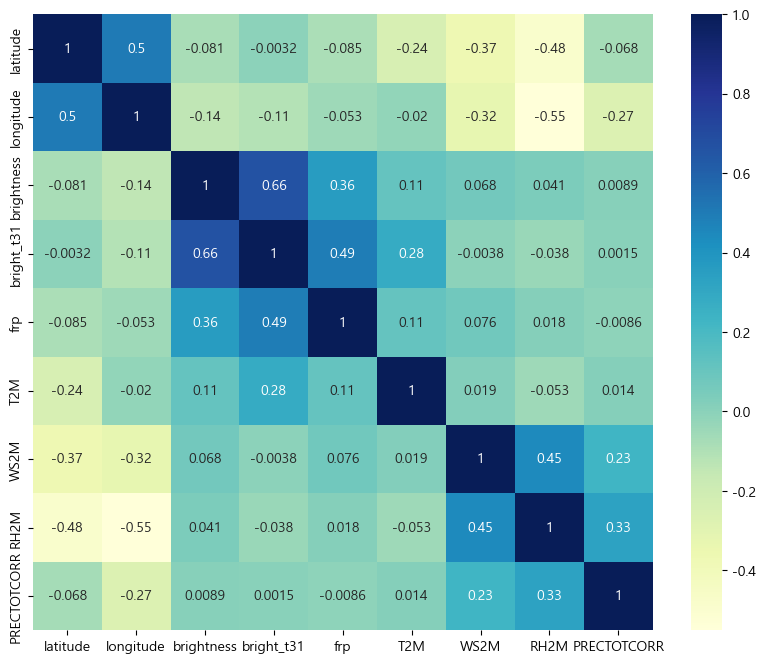

In [13]:
# 상관 관계 시각화
# 'confidence', 'daynight', 'datetime' 열을 제외한 후 상관 관계 계산
corr = australia_pd_data.drop(columns=["confidence", "daynight", "datetime"]).corr()

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

# 해설
# brightness와 bright_t31은 0.67로 강한 양의 상관관계를 보임 → 밝은 불꽃일수록 높은 온도를 가짐.
# frp와 brightness(0.35), bright_t31(0.4)도 양의 상관관계를 가짐 → 더 밝고 뜨거운 불꽃일수록 에너지가 큼.
# RH2M(습도)와 T2M(기온)은 -0.61의 음의 상관관계 → 일반적으로 기온이 높을수록 습도는 낮아짐.
# PRECTOTCORR(강수량)과 대부분의 변수 간 상관관계는 낮음 → 강수량이 FRP에 미치는 영향이 약하거나, 직접적인 관계보다는 시차 효과가 있을 가능성.

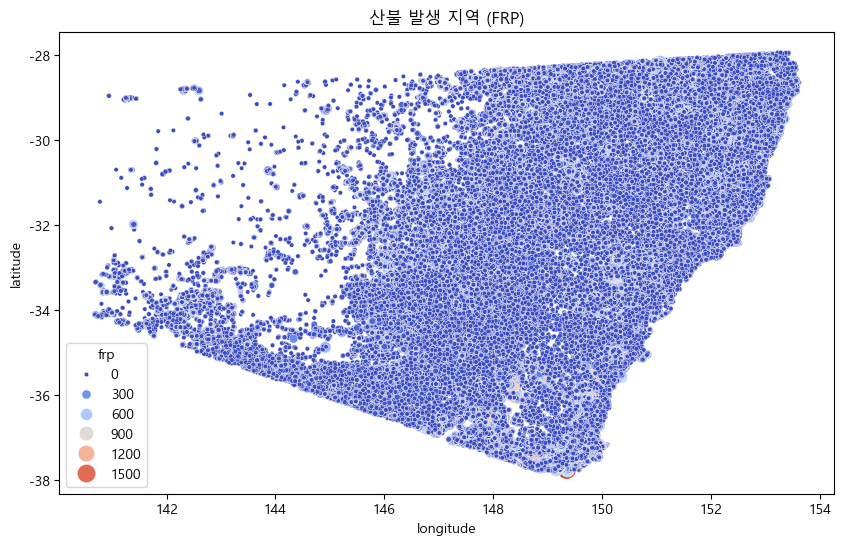

In [14]:
# 산불 발생 지역 시각화 (위도, 경도)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=australia_pd_data, hue='frp', palette='coolwarm', size='frp', sizes=(10, 200))
plt.title('산불 발생 지역 (FRP)')
plt.show()

# 산불 발생 지역 (FRP의 지리적 분포) 해석
# 위도(latitude)와 경도(longitude)를 기준으로 산불 발생 지역을 표시했으며, FRP(Fire Radiative Power, 화재 복사 에너지)가 클수록 색이 붉고 크기가 큼.
# 대부분의 산불이 특정 지역(서부 해안 지역)에 집중되어 있음.
# FRP가 높은 곳(붉은 원)이 일부 지역에 군집되어 있음 → 강한 산불이 특정 지역에서 발생.

In [15]:
print(australia_pd_data.info())
print(australia_pd_data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1175950 entries, 0 to 1175949
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   latitude     1175950 non-null  float64       
 1   longitude    1175950 non-null  float64       
 2   brightness   1175950 non-null  float64       
 3   confidence   1175950 non-null  object        
 4   bright_t31   1175950 non-null  float64       
 5   frp          1175950 non-null  float64       
 6   daynight     1175950 non-null  object        
 7   T2M          1175950 non-null  float64       
 8   WS2M         1175950 non-null  float64       
 9   RH2M         1175950 non-null  float64       
 10  PRECTOTCORR  1175950 non-null  float64       
 11  datetime     1175950 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 116.6+ MB
None
           latitude     longitude    brightness    bright_t31           frp  \
count  1.175950e+06  

In [16]:
# 원핫 인코딩 적용
cleaned_wildfire_df = pd.get_dummies(australia_pd_data, columns=['confidence', 'daynight'], dtype=int)

# 결과 확인
cleaned_wildfire_df.head()

,latitude,longitude,brightness,bright_t31,frp,T2M,WS2M,RH2M,PRECTOTCORR,datetime,confidence_h,confidence_l,confidence_n,daynight_D,daynight_N
0,-34.46005,150.88739,337.26,300.09,6.08,23.542729,3.046357,77.197443,0.438096,2015-01-01 04:02:00,0,0,1,1,0
1,-34.45472,150.87651,336.26,302.46,3.46,23.549633,3.033239,77.120944,0.437495,2015-01-01 04:02:00,0,0,1,1,0
2,-34.46084,150.88281,342.15,302.23,6.08,23.544854,3.039431,77.155237,0.437809,2015-01-01 04:02:00,0,0,1,1,0
3,-33.31349,150.62228,332.79,301.44,3.29,25.627192,0.431325,61.538323,0.385476,2015-01-01 04:03:00,0,0,1,1,0
4,-33.31002,150.62143,338.80,302.00,3.29,25.627632,0.430816,61.535016,0.385449,2015-01-01 04:03:00,0,0,1,1,0


In [17]:
# 로그 변환을 적용할 변수 목록
cols_to_log_transform = ['brightness', 'bright_t31', 'WS2M', 'PRECTOTCORR', 'frp']

# 각 변수에 대해 로그 변환 적용
for col in cols_to_log_transform:
    # np.log1p()는 log(1 + x)를 계산하여 0인 값도 안전하게 처리할 수 있음
    cleaned_wildfire_df[col] = np.log1p(cleaned_wildfire_df[col])

# 결과 확인 (변환된 값들)
cleaned_wildfire_df[cols_to_log_transform].head()

# 주석 해석:
# brightness, bright_t31, WS2M, PRECTOTCORR, frp: 이 변수들은 분포가 비대칭적이거나 극단적인 값들이 존재하여 모델이 잘 학습하지 못할 수 있습니다. 
# 로그 변환을 통해 이러한 분포를 정규 분포에 가깝게 만들 수 있으며, 모델이 더 잘 학습할 수 있도록 돕습니다.
# np.log1p(): log(1 + x)로 0인 값도 변환할 수 있도록 해주는 함수입니다. 
# 이는 0인 값이 있을 수 있는 변수들에 대해서도 안전하게 로그 변환을 수행할 수 있게 도와줍니다.

,brightness,bright_t31,WS2M,PRECTOTCORR,frp
0,5.823815,5.707409,1.397817,0.363320,1.957274
1,5.820854,5.715250,1.394570,0.362902,1.495149
2,5.838168,5.714492,1.396104,0.363121,1.957274
3,5.810512,5.711883,0.358601,0.326043,1.456287
4,5.828357,5.713733,0.358245,0.326024,1.456287


In [18]:
# 날짜 정보 Feature Engineering

cleaned_wildfire_df['year'] = cleaned_wildfire_df['datetime'].dt.year  
cleaned_wildfire_df['month'] = cleaned_wildfire_df['datetime'].dt.month  
cleaned_wildfire_df['day'] = cleaned_wildfire_df['datetime'].dt.day  
cleaned_wildfire_df['season'] = cleaned_wildfire_df['month'] % 12 // 3 + 1  # 1: 겨울, 2: 봄, 3: 여름, 4: 가을  
cleaned_wildfire_df['weekday'] = cleaned_wildfire_df['datetime'].dt.weekday  # 0(월) ~ 6(일)

# datetime 컬럼을 그대로 두는 것보다 연, 월, 일, 계절, 요일 정보를 추출해서 쓰는 게 모델 성능에 도움 된다고 판단

# Feature Engineering이 완료된 데이터프레임 확인
cleaned_wildfire_df[['year', 'month', 'day', 'season', 'weekday']].head()

,year,month,day,season,weekday
0,2015,1,1,1,3
1,2015,1,1,1,3
2,2015,1,1,1,3
3,2015,1,1,1,3
4,2015,1,1,1,3


In [19]:
cleaned_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1175950 entries, 0 to 1175949
Data columns (total 20 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   latitude      1175950 non-null  float64       
 1   longitude     1175950 non-null  float64       
 2   brightness    1175950 non-null  float64       
 3   bright_t31    1175950 non-null  float64       
 4   frp           1175950 non-null  float64       
 5   T2M           1175950 non-null  float64       
 6   WS2M          1175950 non-null  float64       
 7   RH2M          1175950 non-null  float64       
 8   PRECTOTCORR   1175950 non-null  float64       
 9   datetime      1175950 non-null  datetime64[ns]
 10  confidence_h  1175950 non-null  int32         
 11  confidence_l  1175950 non-null  int32         
 12  confidence_n  1175950 non-null  int32         
 13  daynight_D    1175950 non-null  int32         
 14  daynight_N    1175950 non-null  int32         
 15  yea

In [20]:
### 풍속과 습도의 상호작용 특성 (Wind Speed * Humidity Interaction)
# 산불 발생에 있어 풍속과 습도는 중요한 변수입니다. 특히, 풍속이 빠를수록 산불이 확산되며, 습도가 낮을수록 산불의 확산 속도는 증가할 수 있습니다. 이를 반영한 상호작용 특성을 추가합니다.

cleaned_wildfire_df['WS2M_RH2M_interaction'] = cleaned_wildfire_df['WS2M'] * cleaned_wildfire_df['RH2M']

# 설명: 풍속(WS2M)과 습도(RH2M)는 산불의 확산에 중요한 영향을 미칩니다. 
#       풍속이 빠를수록 불이 빠르게 퍼지고, 습도가 낮을수록 불이 강하게 확산
# 효과: 풍속과 습도가 산불 강도에 미치는 영향을 독립적으로 고려하는 것보다 상호작용 특성을 반영함으로써 더 나은 모델링이 가능할 것으로 예상

In [21]:
### 고온 여부 (High Temperature Flag)
# 기온(T2M)이 특정 임계값을 초과하는지 여부를 확인하여, 고온 여부를 나타내는 이진 특성을 생성합니다. 예를 들어, 30°C 이상의 기온을 고온으로 설정할 수 있습니다.

cleaned_wildfire_df['high_temperature'] = (cleaned_wildfire_df['T2M'] > 30).astype(int)
# 이 특성은 산불 발생과 고온 간의 관계를 모델링하는 데 도움이 될 수 있습니다.

# 설명: 30°C 이상의 기온을 고온 여부로 변환하는 특성을 추가하는 것은 산불 발생의 중요한 특징을 반영한 것입니다. 
#       높은 기온은 산불 발생 가능성을 크게 높입니다.
# 효과: 고온을 이진 변수로 처리하여 기온이 일정 수준 이상일 때 산불 확산 가능성에 미치는 영향을 명확히 반영할 수 있습니다.

In [22]:
### 습도 범주화 (Humidity Binning)
# 습도(RH2M)가 산불에 미치는 영향을 더 잘 모델링하려면, 습도를 몇 가지 구간으로 나누어 범주화할 수 있습니다. 예를 들어, 저습도, 중간습도, 고습도로 나눌 수 있습니다.

# 습도 범주화 (Humidity Binning)
humidity_bins = [0, 30, 60, 100]
humidity_labels = ['low', 'medium', 'high']
cleaned_wildfire_df['RH2M_binned'] = pd.cut(cleaned_wildfire_df['RH2M'], 
                                            bins=humidity_bins, 
                                            labels=humidity_labels, 
                                            include_lowest=True)

In [23]:
### 기온 범주화 (Temperature Binning)
# 기온(T2M)을 몇 가지 범주로 나누어, 고온과 저온을 구분하는 변수를 추가할 수 있습니다. 

# 기온 범주화 (Temperature Binning)
temperature_bins = [-5, 15, 30, 45]  # 최소값 -5°C 반영
temperature_labels = ['low', 'medium', 'high']
cleaned_wildfire_df['T2M_binned'] = pd.cut(cleaned_wildfire_df['T2M'], 
                                           bins=temperature_bins, 
                                           labels=temperature_labels, 
                                           include_lowest=True)

# 설명: **기온(T2M)**을 세 개의 범주로 나누어 고온, 중온, 저온을 구분하는 변수를 추가하는 것도 좋은 접근입니다. 
#       기온이 높을수록 산불 발생의 가능성이 높아지기 때문에 이 범주화를 통해 모델이 기온의 범위에 따라 어떻게 반응하는지 파악할 수 있습니다.
# 효과: 기온을 이진 변수로 처리하는 것보다 더 구체적인 범주로 나누어 기온이 산불에 미치는 영향을 더 세밀하게 분석할 수 있게 됩니다.

In [24]:
### 강수량 여부 (Precipitation Flag)
# 강수량 (PRECTOTCORR)이 0인 경우에는 강수량 없음으로, 그렇지 않으면 강수량 있음으로 구분하는 이진 특성을 추가합니다.
# 강수량이 많으면 산불 발생이 줄어들 수 있으므로 이 특성은 예측 모델에 중요한 영향을 미칠 수 있습니다.

cleaned_wildfire_df['precipitation_flag'] = (cleaned_wildfire_df['PRECTOTCORR'] > 0).astype(int)

In [25]:
# 피처 엔지니어링 요약
# 피처 엔지니어링을 통해 추가할 수 있는 특성들:

# 풍속과 습도의 상호작용 특성 (WS2M_RH2M_interaction): 풍속과 습도의 상호작용을 나타내는 특성.
# 고온 여부 (high_temperature): 기온이 30도 이상인 경우를 고온으로 표시하는 특성.
# 습도 범주화 (RH2M_binned): 습도를 저, 중, 고로 구분하여 범주형 특성으로 추가.
# 기온 범주화 (T2M_binned): 기온을 저, 중, 고온으로 범주화하여 모델링에 활용.
# 강수량 여부 (precipitation_flag): 강수량이 0인지 아닌지에 따라 산불 발생과의 관계를 반영할 수 있는 이진 특성.

In [26]:
cleaned_wildfire_df.head()

,latitude,longitude,brightness,bright_t31,frp,T2M,WS2M,RH2M,PRECTOTCORR,datetime,...,year,month,day,season,weekday,WS2M_RH2M_interaction,high_temperature,RH2M_binned,T2M_binned,precipitation_flag
0,-34.46005,150.88739,5.823815,5.707409,1.957274,23.542729,1.397817,77.197443,0.363320,2015-01-01 04:02:00,...,2015,1,1,1,3,107.907902,0,high,medium,1
1,-34.45472,150.87651,5.820854,5.715250,1.495149,23.549633,1.394570,77.120944,0.362902,2015-01-01 04:02:00,...,2015,1,1,1,3,107.550533,0,high,medium,1
2,-34.46084,150.88281,5.838168,5.714492,1.957274,23.544854,1.396104,77.155237,0.363121,2015-01-01 04:02:00,...,2015,1,1,1,3,107.716724,0,high,medium,1
3,-33.31349,150.62228,5.810512,5.711883,1.456287,25.627192,0.358601,61.538323,0.326043,2015-01-01 04:03:00,...,2015,1,1,1,3,22.067694,0,high,medium,1
4,-33.31002,150.62143,5.828357,5.713733,1.456287,25.627632,0.358245,61.535016,0.326024,2015-01-01 04:03:00,...,2015,1,1,1,3,22.044616,0,high,medium,1


In [27]:
# 불필요한 컬럼 삭제
# 'datetime' 컬럼은 이미 연도, 월, 일, 요일, 계절 등의 정보를 나누었으므로 삭제
cleaned_wildfire_df.drop(columns=['datetime'], inplace=True)

# 결과 확인
cleaned_wildfire_df.head()

,latitude,longitude,brightness,bright_t31,frp,T2M,WS2M,RH2M,PRECTOTCORR,confidence_h,...,year,month,day,season,weekday,WS2M_RH2M_interaction,high_temperature,RH2M_binned,T2M_binned,precipitation_flag
0,-34.46005,150.88739,5.823815,5.707409,1.957274,23.542729,1.397817,77.197443,0.363320,0,...,2015,1,1,1,3,107.907902,0,high,medium,1
1,-34.45472,150.87651,5.820854,5.715250,1.495149,23.549633,1.394570,77.120944,0.362902,0,...,2015,1,1,1,3,107.550533,0,high,medium,1
2,-34.46084,150.88281,5.838168,5.714492,1.957274,23.544854,1.396104,77.155237,0.363121,0,...,2015,1,1,1,3,107.716724,0,high,medium,1
3,-33.31349,150.62228,5.810512,5.711883,1.456287,25.627192,0.358601,61.538323,0.326043,0,...,2015,1,1,1,3,22.067694,0,high,medium,1
4,-33.31002,150.62143,5.828357,5.713733,1.456287,25.627632,0.358245,61.535016,0.326024,0,...,2015,1,1,1,3,22.044616,0,high,medium,1


In [28]:
# 결과 확인
cleaned_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1175950 entries, 0 to 1175949
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   latitude               1175950 non-null  float64 
 1   longitude              1175950 non-null  float64 
 2   brightness             1175950 non-null  float64 
 3   bright_t31             1175950 non-null  float64 
 4   frp                    1175950 non-null  float64 
 5   T2M                    1175950 non-null  float64 
 6   WS2M                   1175950 non-null  float64 
 7   RH2M                   1175950 non-null  float64 
 8   PRECTOTCORR            1175950 non-null  float64 
 9   confidence_h           1175950 non-null  int32   
 10  confidence_l           1175950 non-null  int32   
 11  confidence_n           1175950 non-null  int32   
 12  daynight_D             1175950 non-null  int32   
 13  daynight_N             1175950 non-null  int32   
 14  year   

In [29]:
# 범주형 변수에 대해 원-핫 인코딩 처리 (T2M_binned, RH2M_binned)
cleaned_wildfire_df = pd.get_dummies(cleaned_wildfire_df, columns=['T2M_binned', 'RH2M_binned'], drop_first=True)

# 상관관계 계산
correlation_matrix = cleaned_wildfire_df.corr()

# 상관관계 행렬 출력 (상위 몇 개를 확인할 수 있습니다)
print(correlation_matrix.head())

            latitude  longitude  brightness  bright_t31       frp       T2M  \
latitude    1.000000   0.503695   -0.080861   -0.001397 -0.127761 -0.242738   
longitude   0.503695   1.000000   -0.142633   -0.112902 -0.121217 -0.020292   
brightness -0.080861  -0.142633    1.000000    0.657695  0.756251  0.112914   
bright_t31 -0.001397  -0.112902    0.657695    1.000000  0.652292  0.286880   
frp        -0.127761  -0.121217    0.756251    0.652292  1.000000  0.146909   

                WS2M      RH2M  PRECTOTCORR  confidence_h  ...       day  \
latitude   -0.330098 -0.484767    -0.112261     -0.021869  ... -0.001094   
longitude  -0.328499 -0.550865    -0.359117     -0.046524  ... -0.044407   
brightness  0.067630  0.040766     0.010249      0.472497  ... -0.017371   
bright_t31  0.005174 -0.039044    -0.013836      0.303336  ... -0.029304   
frp         0.088386  0.035342    -0.003240      0.374473  ... -0.030844   

              season   weekday  WS2M_RH2M_interaction  high_temperat

In [30]:
cleaned_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1175950 entries, 0 to 1175949
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   latitude               1175950 non-null  float64
 1   longitude              1175950 non-null  float64
 2   brightness             1175950 non-null  float64
 3   bright_t31             1175950 non-null  float64
 4   frp                    1175950 non-null  float64
 5   T2M                    1175950 non-null  float64
 6   WS2M                   1175950 non-null  float64
 7   RH2M                   1175950 non-null  float64
 8   PRECTOTCORR            1175950 non-null  float64
 9   confidence_h           1175950 non-null  int32  
 10  confidence_l           1175950 non-null  int32  
 11  confidence_n           1175950 non-null  int32  
 12  daynight_D             1175950 non-null  int32  
 13  daynight_N             1175950 non-null  int32  
 14  year                   

In [31]:
# 독립변수 X와 종속변수 y 정의
X = cleaned_wildfire_df[["brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR", "confidence_h",
                         "confidence_l", "confidence_n", "daynight_D", "daynight_N", "WS2M_RH2M_interaction",
                         "high_temperature", "precipitation_flag", "T2M_binned_medium", "T2M_binned_high", 
                         "RH2M_binned_medium", "RH2M_binned_high"]]
y = cleaned_wildfire_df["frp"]

# 스피어만 상관관계 검증
for value in X:
    # Spearman 상관계수 계산
    statistic, pvalue = spearmanr(X[value], y)
    
    # 유의미한 상관관계 판단
    if pvalue < 0.05:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue} => ({value}) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.")
    else:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue} => ({value}) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가지지 않는다.")


상관관계 계수 0.847, p-value 0.0 => (brightness) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.676, p-value 0.0 => (bright_t31) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.128, p-value 0.0 => (T2M) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.083, p-value 0.0 => (WS2M) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.059, p-value 0.0 => (RH2M) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.005, p-value 1.0799714403951244e-08 => (PRECTOTCORR) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.341, p-value 0.0 => (confidence_h) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.178, p-value 0.0 => (confidence_l) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.389, p-value 0.0 => (confidence_n) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.686, p-value 0.0 => (daynight_D) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.686, p-value 0.0 => (daynight_N) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.078, p-value 0.0 => (WS2M_RH2M_interaction) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.018, p-value 7.644344325509786e-84 => (high_temperature) 독

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2500\1968479772.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  statistic, pvalue = spearmanr(X[value], y)


상관관계 계수 0.099, p-value 0.0 => (T2M_binned_medium) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.018, p-value 7.644344325509786e-84 => (T2M_binned_high) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 -0.022, p-value 4.6940161791220335e-127 => (RH2M_binned_medium) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.
상관관계 계수 0.022, p-value 2.5876594070040415e-126 => (RH2M_binned_high) 독립변수는 종속변수(FRP)와 유의미한 상관관계를 가진다.


#### 데이터 시각화

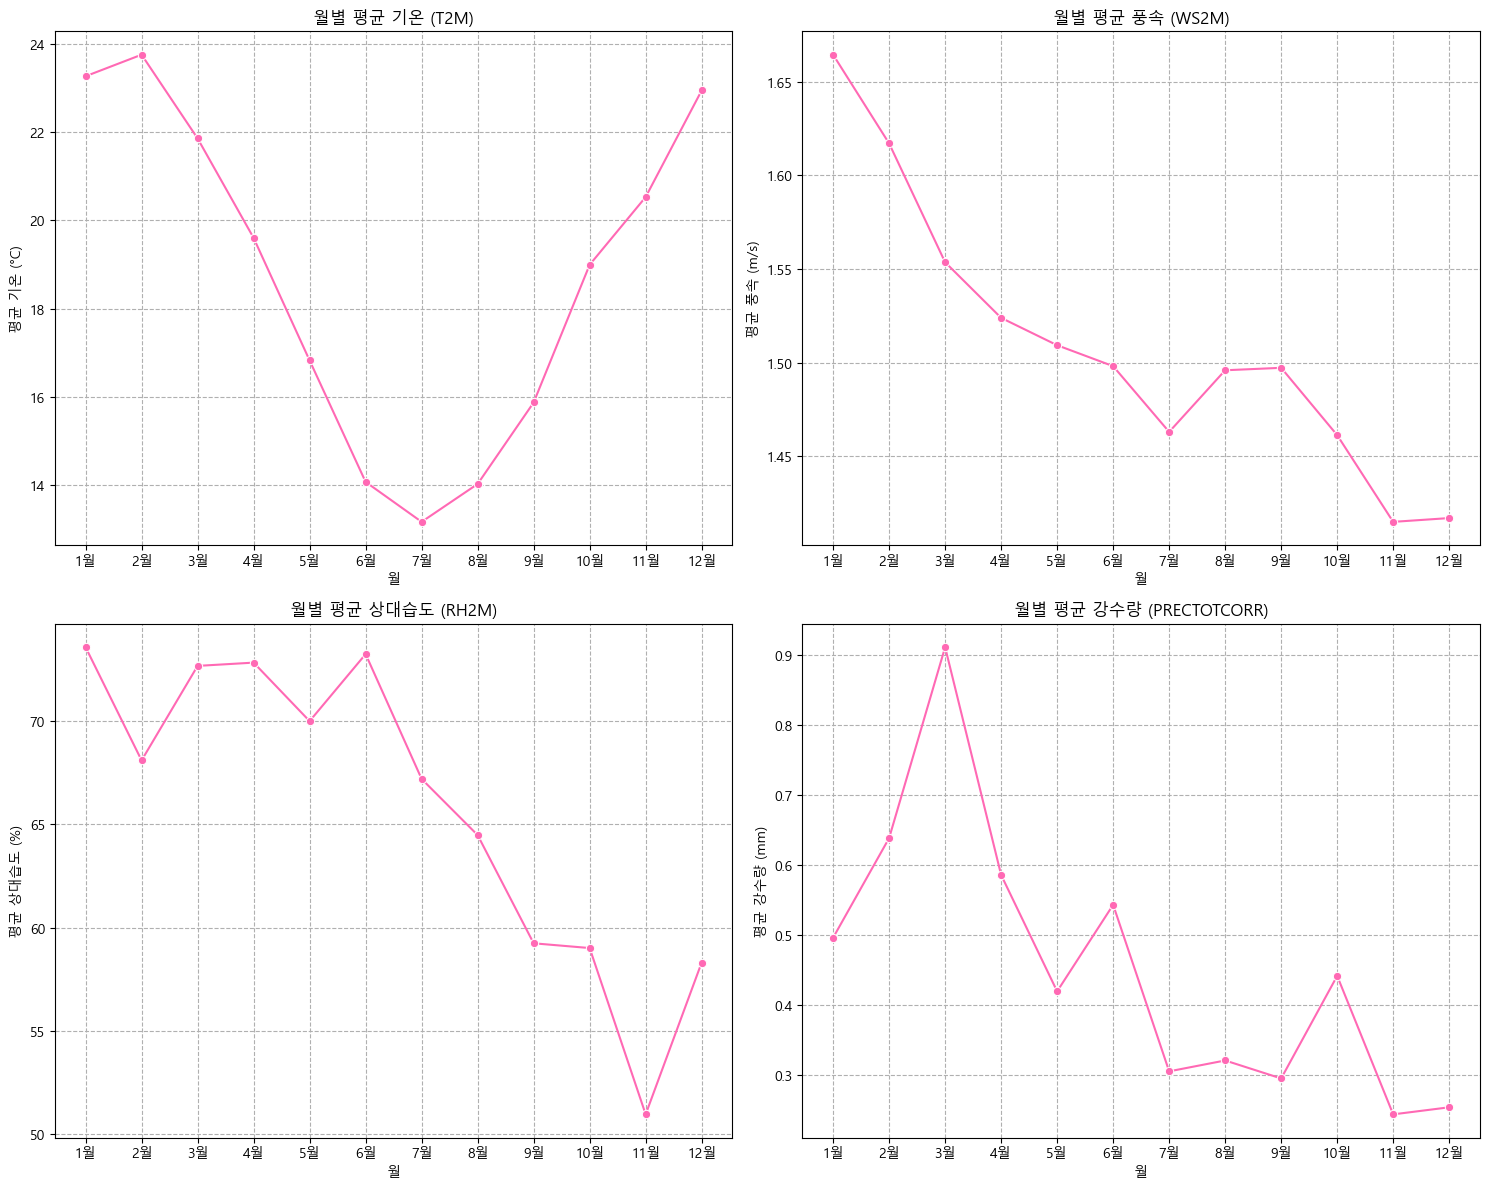

In [33]:
# 월별 평균값 계산
monthly_avg_temp = cleaned_wildfire_df.groupby('month')['T2M'].mean().reset_index()
monthly_avg_wind = cleaned_wildfire_df.groupby('month')['WS2M'].mean().reset_index()
monthly_avg_humidity = cleaned_wildfire_df.groupby('month')['RH2M'].mean().reset_index()
monthly_avg_precipitation = cleaned_wildfire_df.groupby('month')['PRECTOTCORR'].mean().reset_index()

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 첫 번째 그래프: 월별 평균 온도(T2M)
sns.lineplot(x='month', y='T2M', c="hotpink", data=monthly_avg_temp, marker='o', ax=axes[0, 0])
axes[0, 0].set_title('월별 평균 기온 (T2M)')
axes[0, 0].set_xlabel('월')
axes[0, 0].set_ylabel('평균 기온 (°C)')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
axes[0, 0].grid(True, linestyle="--")

# 두 번째 그래프: 월별 평균 풍속(WS2M)
sns.lineplot(x='month', y='WS2M', c="hotpink", data=monthly_avg_wind, marker='o', ax=axes[0, 1])
axes[0, 1].set_title('월별 평균 풍속 (WS2M)')
axes[0, 1].set_xlabel('월')
axes[0, 1].set_ylabel('평균 풍속 (m/s)')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
axes[0, 1].grid(True, linestyle="--")

# 세 번째 그래프: 월별 평균 상대습도(RH2M)
sns.lineplot(x='month', y='RH2M', c="hotpink", data=monthly_avg_humidity, marker='o', ax=axes[1, 0])
axes[1, 0].set_title('월별 평균 상대습도 (RH2M)')
axes[1, 0].set_xlabel('월')
axes[1, 0].set_ylabel('평균 상대습도 (%)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
axes[1, 0].grid(True, linestyle="--")

# 네 번째 그래프: 월별 평균 강수량(PRECTOTCORR)
sns.lineplot(x='month', y='PRECTOTCORR', c="hotpink", data=monthly_avg_precipitation, marker='o', ax=axes[1, 1])
axes[1, 1].set_title('월별 평균 강수량 (PRECTOTCORR)')
axes[1, 1].set_xlabel('월')
axes[1, 1].set_ylabel('평균 강수량 (mm)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
axes[1, 1].grid(True, linestyle="--")

# 레이아웃 조정
plt.tight_layout()
plt.show()

#### 사용할 최종 데이터 CSV 파일 저장

In [ ]:
# # 저장 (필요한 경우)
# cleaned_wildfire_df.to_csv("./data/csv/australia_cleaned_wildfire.csv", index=False)